In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline 

Loading the Feature Vector. Here we extracted the Sherlock video with the [SoundNet](http://soundnet.csail.mit.edu/) pretrained network, and we use layer number 19 


In [2]:
file_fv = '../features/sherlock_layer_19.npy'

fv = np.load(file_fv)

# Check the size
print(fv.shape)
print("%d time points, dimension of the FV is %d" % fv.shape)

(946, 512)
946 time points, dimension of the FV is 512


Now we load the fMRI data. 

First we need to prepare a "Masker". The data itself comes with a binary "mask" file, which identifies which voxels belong to the brain. We need the mask in order to extract only the voxels that contain relevant information. This is done by the NiftiMasker object in nilearn. 

More on masking [here](http://nilearn.github.io/manipulating_images/masker_objects.html)

In [12]:
from nilearn.input_data import NiftiMasker
filename_mask = '../fMRI/sub-01_task-SherlockMovie_bold_space-T1w_brainmask.nii.gz'

masker = NiftiMasker(mask_img=filename_mask, detrend=True,standardize=True)
masker.fit()

NiftiMasker(detrend=True, dtype=None, high_pass=None, low_pass=None,
            mask_args=None,
            mask_img='../fMRI/sub-01_task-SherlockMovie_bold_space-T1w_brainmask.nii.gz',
            mask_strategy='background', memory=Memory(location=None),
            memory_level=1, sample_mask=None, sessions=None,
            smoothing_fwhm=None, standardize=True, t_r=None, target_affine=None,
            target_shape=None, verbose=0)

We are now ready to load the fMRI data. We need to drop a few time points at the beginning, because the scanner started before the video starts. 

In [7]:
filename_irm = '../fMRI/sub-01_task-SherlockMovie_bold_space-T1w_preproc.nii.gz'

fmri_data = masker.transform(filename_irm)

In [8]:
print(fmri_data.shape)

(967, 44690)


In [4]:
fmri_ready = fmri_data[17:-(fmri_data.shape[0]-17-fv.shape[0])]


(967, 44690) (946, 44690)


We can have a look at the average over time of all images. This will show the structure of the brain of the particular subject

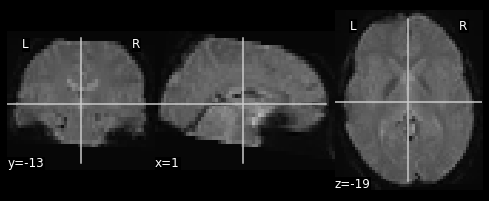

In [5]:
from nilearn.image import mean_img
from nilearn.plotting import plot_anat
fmri_mean = mean_img(filename_irm)

plot_anat(fmri_mean)

In [6]:
# building the encoding models
middle = int(fv.shape[0]/2)
y_train = fmri_ready[:middle] 
y_test = fmri_ready[middle:]
X_train = (fv[:middle])
X_test = (fv[middle:])

And finally we can estimate our model of brain activity. We use Ridge Regression here, which is a linear regression with a penalty on the L2 norm. More on Ridge [here](http://scikit-learn.org/stable/modules/linear_model.html#ridge-regression). 

We train Ridge using the fit method on the training set, and we predict brain activity on the test set. 

In [11]:
from sklearn.linear_model import Ridge, RidgeCV

estimator = RidgeCV(alphas=[1000,5000,15000,25000]) # Alpha value has been explored before

estimator.fit(X_train,y_train)
predictions = estimator.predict(X_test)

In [ ]:
10, 150, 1500, 2000

Finally, we measure the quality of prediction using R2 score, which estimates how much the predictions and the true values are linearly related. 
We eliminate the negative scores which correspond to failed predictions. 

The R2 score is estimated for each voxel in the brain. 

In [12]:
from sklearn.metrics import r2_score
scores = r2_score(y_test, predictions, multioutput='raw_values')
scores[scores < 0] = 0

We can project the R2 map on the brain (using the inverse_transform method of the masker) to see which voxels are the most predictive. 

In [13]:

scores_img = masker.inverse_transform(scores)


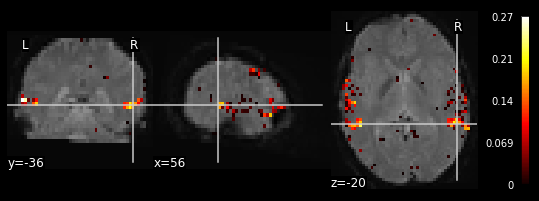

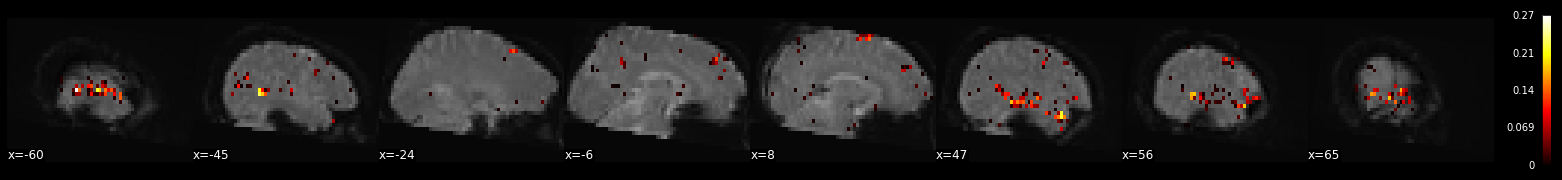

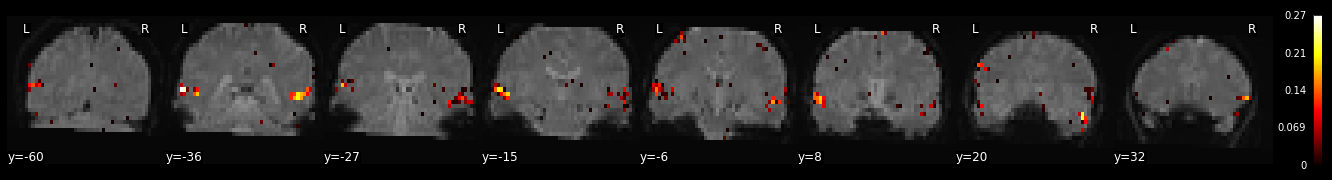

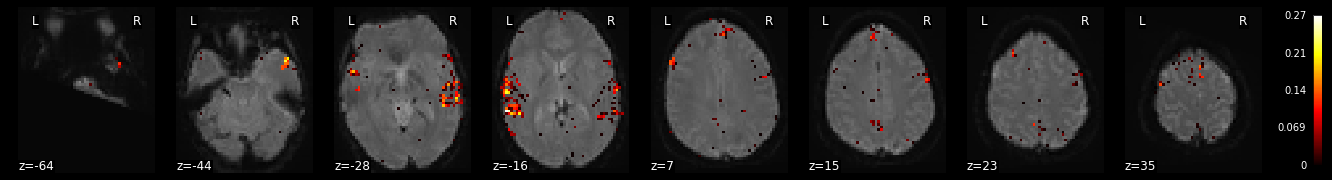

In [14]:
from nilearn.plotting import plot_stat_map
plot_stat_map(scores_img,bg_img=fmri_mean)
plt.show()
plot_stat_map(scores_img,bg_img=fmri_mean,cut_coords=8,display_mode='x')
plt.show()
plot_stat_map(scores_img,bg_img=fmri_mean,cut_coords=8,display_mode='y')
plt.show()
plot_stat_map(scores_img,bg_img=fmri_mean,cut_coords=8,display_mode='z')
plt.show()

In [104]:

#using the feature vector as stimuli
#to predict the neuronal activity in this voxel. (Pytorchmodel)

def get_scores(id, alphas = [1e-6,1e-5,1e-2,1]):
    curnpz = "/home/brain/Desktop/BrainSongs/audiosummary_private/sherlock_pytorch/"
    curnpz = "{}conv{}.npz".format(curnpz,id+1)
    fv = np.load(curnpz)['fv']

    # Check the size
    print(fv.shape)
    print("%d time points, dimension of the FV is %d" % fv.shape)    

    stimuli = fv
    dim = fv.shape[1]
    #estimator = RidgeCV(alphas=[1e-6,1e-5,1e-2,1])
    cv = KFold(n_splits=10)

    scores = []
    for train, test in tqdm(cv.split(X=stimuli)):
        # we train the Ridge estimator on the training set
        # and predict the fMRI activity for the test set
        predictions = RidgeCV(alphas=alphas).fit(
        stimuli.reshape(-1, dim)[train], fmri_data[train]).predict(
            stimuli.reshape(-1, dim)[test])
        # we compute how much variance our encoding model explains in each voxel
        scores.append(r2_score(fmri_data[test], predictions,
                               multioutput='raw_values'))
    #To plot the scores onto the brain, we create a Nifti1Image containing the scores 
    cut_score = np.mean(scores, axis=0)
    cut_score[cut_score < 0] = 0    
    return cut_score

In [9]:
conv1 = get_scores(0)

0it [00:00, ?it/s]

(946, 16)
946 time points, dimension of the FV is 16


10it [00:50,  5.10s/it]


In [11]:
conv2 = get_scores(1)

0it [00:00, ?it/s]

(946, 32)
946 time points, dimension of the FV is 32


10it [00:49,  4.91s/it]


In [13]:
conv3 = get_scores(2)


0it [00:00, ?it/s]

(946, 64)
946 time points, dimension of the FV is 64



1it [00:05,  5.21s/it]
2it [00:10,  5.16s/it]
3it [00:15,  5.09s/it]
4it [00:20,  5.05s/it]
5it [00:25,  5.01s/it]
6it [00:29,  4.99s/it]
7it [00:35,  5.02s/it]
8it [00:40,  5.01s/it]
9it [00:45,  5.00s/it]
10it [00:50,  5.09s/it]

In [14]:
conv4 = get_scores(3)


0it [00:00, ?it/s]

(946, 128)
946 time points, dimension of the FV is 128



1it [00:05,  5.37s/it]
2it [00:10,  5.32s/it]
3it [00:15,  5.31s/it]
4it [00:21,  5.28s/it]
5it [00:26,  5.24s/it]
6it [00:31,  5.28s/it]
7it [00:36,  5.26s/it]
8it [00:41,  5.22s/it]
9it [00:47,  5.21s/it]
10it [00:52,  5.21s/it]

In [15]:
conv5 = get_scores(4)


0it [00:00, ?it/s]

(946, 256)
946 time points, dimension of the FV is 256



1it [00:05,  5.84s/it]
2it [00:11,  5.86s/it]
3it [00:17,  5.86s/it]
4it [00:23,  5.87s/it]
5it [00:29,  5.87s/it]
6it [00:35,  5.85s/it]
7it [00:41,  5.90s/it]
8it [00:47,  6.04s/it]
9it [00:54,  6.23s/it]
10it [01:00,  6.12s/it]

In [16]:
conv6 = get_scores(5)


0it [00:00, ?it/s]

(946, 512)
946 time points, dimension of the FV is 512



1it [00:07,  7.84s/it]
2it [00:15,  7.77s/it]
3it [00:22,  7.60s/it]
4it [00:30,  7.56s/it]
5it [00:38,  7.70s/it]
6it [00:46,  7.90s/it]
7it [00:54,  7.92s/it]
8it [01:02,  8.06s/it]
9it [01:10,  8.08s/it]
10it [01:18,  7.80s/it]

In [17]:
conv7 = get_scores(6)


0it [00:00, ?it/s]

(946, 1024)
946 time points, dimension of the FV is 1024



1it [00:07,  7.79s/it]
2it [00:15,  7.78s/it]
3it [00:23,  7.91s/it]
4it [00:32,  8.14s/it]
5it [00:40,  8.03s/it]
6it [00:48,  7.98s/it]
7it [00:55,  7.90s/it]
8it [01:03,  7.87s/it]
9it [01:11,  7.92s/it]
10it [01:19,  7.90s/it]

# test

In [3]:
curnpz = "/home/brain/Desktop/BrainSongs/audiosummary_private/sherlock_pytorch/conv7.npz"
fv = np.load(curnpz)['fv']

# Check the size
print(fv.shape)
print("%d time points, dimension of the FV is %d" % fv.shape)

(946, 1024)
946 time points, dimension of the FV is 1024


In [4]:
from nilearn.input_data import NiftiMasker
filename_mask = '../fMRI/sub-01_task-SherlockMovie_bold_space-T1w_brainmask.nii.gz'

masker = NiftiMasker(mask_img=filename_mask, detrend=True,standardize=True)
masker.fit()

/home/brain/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


NiftiMasker(detrend=True, dtype=None, high_pass=None, low_pass=None,
            mask_args=None,
            mask_img='../fMRI/sub-01_task-SherlockMovie_bold_space-T1w_brainmask.nii.gz',
            mask_strategy='background', memory=Memory(location=None),
            memory_level=1, sample_mask=None, sessions=None,
            smoothing_fwhm=None, standardize=True, t_r=None, target_affine=None,
            target_shape=None, verbose=0)

In [5]:
filename_irm = '../fMRI/sub-01_task-SherlockMovie_bold_space-T1w_preproc.nii.gz'
fmri_data = masker.transform(filename_irm)
fmri_data = fmri_data[17:-(fmri_data.shape[0]-17-fv.shape[0])]
print(fmri_data.shape)

(946, 44690)


> fmri_data is a matrix of samples x voxels

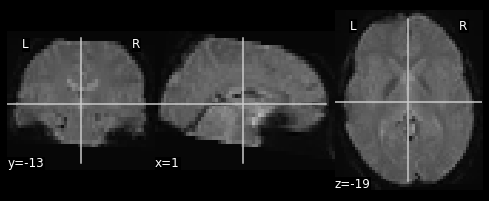

In [6]:
from nilearn.image import mean_img
from nilearn.plotting import plot_anat
fmri_mean = mean_img(filename_irm)

plot_anat(fmri_mean)

https://nilearn.github.io/auto_examples/02_decoding/plot_miyawaki_encoding.html

> Using 10-fold cross-validation, we partition the data into 10 ‘folds’. We hold out each fold of the data for testing, then fit a ridge regression to the remaining 9/10 of the data, using stimuli as predictors and fmri_data as targets, and create predictions for the held-out 10th.



In [1]:
from sklearn.linear_model import Ridge,RidgeCV
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from tqdm import tqdm

In [19]:
import pandas as pd
df = pd.DataFrame({'conv1':conv1,'conv2':conv2,'conv3':conv3,
                   'conv4':conv4,'conv5':conv5,'conv6':conv6,
                   'conv7':conv7})

In [22]:
df.describe()

,conv1,conv2,conv3,conv4,conv5,conv6,conv7
count,44690.000000,44690.000000,44690.000000,44690.000000,44690.000000,44690.000000,44690.000000
mean,0.000025,0.000016,0.000044,0.000074,0.000214,0.000068,0.000852
std,0.000759,0.000573,0.000875,0.001336,0.002955,0.001463,0.009415
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.057454,0.048735,0.049871,0.065288,0.123923,0.086173,0.266147


In [46]:
best_scores = pd.DataFrame({'scores' : df.max(axis=1),'layer':df.idxmax(axis=1)})
best_scores.head()

,scores,layer
0,0.0,conv1
1,0.0,conv1
2,0.0,conv1
3,0.0,conv1
4,0.0,conv1


In [47]:
# bring the scores into the shape of the background brain
score_map_img = masker.inverse_transform(best_scores['scores'])

In [48]:
score_map_img.shape

(52, 63, 37)

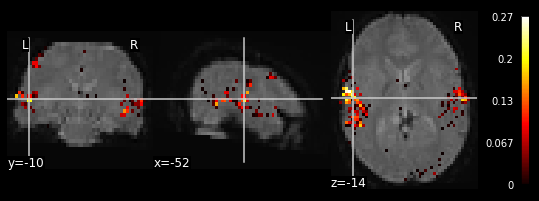

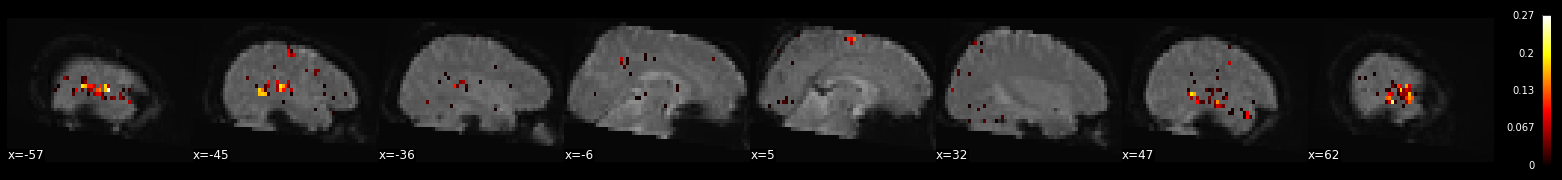

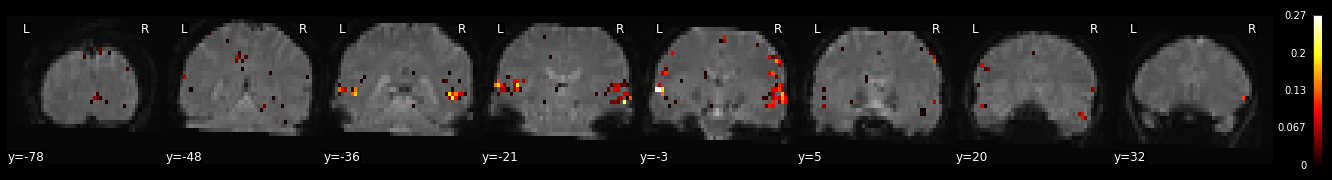

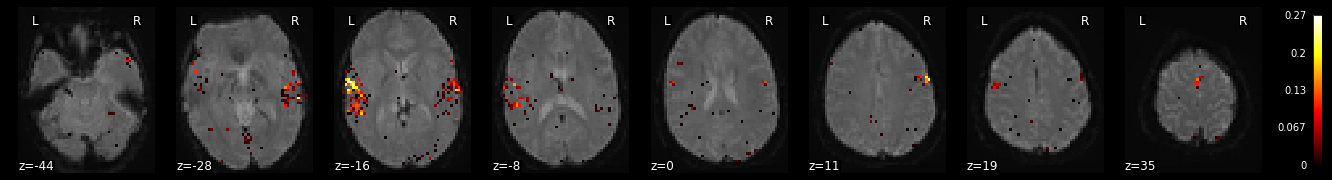

In [51]:
from nilearn.plotting import plot_stat_map,plot_glass_brain
plot_stat_map(score_map_img,bg_img=fmri_mean)
plt.show()
plot_stat_map(score_map_img,bg_img=fmri_mean,cut_coords=8,display_mode='x')
plt.show()
plot_stat_map(score_map_img,bg_img=fmri_mean,cut_coords=8,display_mode='y')
plt.show()
plot_stat_map(score_map_img,bg_img=fmri_mean,cut_coords=8,display_mode='z')
plt.show()

In [75]:
best_scores.groupby(['layer']).count()

,scores
layer,
conv1,43786
conv2,10
conv3,43
conv4,60
conv5,87
conv6,27
conv7,677


# sujet2

In [88]:
from nilearn.input_data import NiftiMasker
filename_mask = '../fMRI/sub-02_task-SherlockMovie_bold_space-T1w_brainmask.nii.gz'

masker = NiftiMasker(mask_img=filename_mask, detrend=True,standardize=True)
masker.fit()

NiftiMasker(detrend=True, dtype=None, high_pass=None, low_pass=None,
            mask_args=None,
            mask_img='../fMRI/sub-02_task-SherlockMovie_bold_space-T1w_brainmask.nii.gz',
            mask_strategy='background', memory=Memory(location=None),
            memory_level=1, sample_mask=None, sessions=None,
            smoothing_fwhm=None, standardize=True, t_r=None, target_affine=None,
            target_shape=None, verbose=0)

In [89]:
filename_irm = '../fMRI/sub-02_task-SherlockMovie_bold_space-T1w_preproc.nii.gz'
fmri_data = masker.transform(filename_irm)
fmri_data = fmri_data[17:-(fmri_data.shape[0]-17-fv.shape[0])]
print(fmri_data.shape)

(946, 22226)


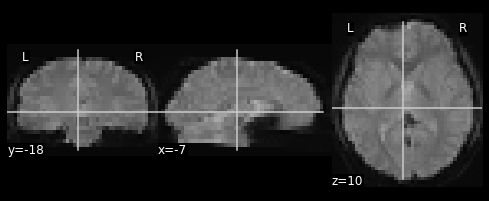

In [90]:
from nilearn.image import mean_img
from nilearn.plotting import plot_anat
fmri_mean = mean_img(filename_irm)

plot_anat(fmri_mean)

In [105]:
alpha = [1e-3,1,1e2,1e3]

In [106]:
conv1 = get_scores(0,alpha)


0it [00:00, ?it/s]

(946, 16)
946 time points, dimension of the FV is 16



1it [00:02,  2.50s/it]
2it [00:04,  2.49s/it]
3it [00:07,  2.47s/it]
4it [00:09,  2.45s/it]
5it [00:12,  2.51s/it]
6it [00:15,  2.53s/it]
7it [00:17,  2.57s/it]
8it [00:20,  2.56s/it]
9it [00:22,  2.52s/it]
10it [00:25,  2.48s/it]

In [107]:
conv2 = get_scores(1,alpha)


0it [00:00, ?it/s]

(946, 32)
946 time points, dimension of the FV is 32



1it [00:02,  2.54s/it]
2it [00:05,  2.54s/it]
3it [00:07,  2.53s/it]
4it [00:10,  2.53s/it]
5it [00:12,  2.57s/it]
6it [00:15,  2.55s/it]
7it [00:18,  2.61s/it]
8it [00:20,  2.62s/it]
9it [00:23,  2.57s/it]
10it [00:25,  2.53s/it]

In [ ]:
conv3 = get_scores(2,alpha)


0it [00:00, ?it/s]

(946, 64)
946 time points, dimension of the FV is 64



1it [00:02,  2.63s/it]
2it [00:05,  2.58s/it]
3it [00:07,  2.55s/it]

In [94]:
conv4 = get_scores(3,alpha)


0it [00:00, ?it/s]

(946, 128)
946 time points, dimension of the FV is 128



1it [00:02,  2.48s/it]
2it [00:05,  2.56s/it]
3it [00:07,  2.52s/it]
4it [00:10,  2.52s/it]
5it [00:12,  2.50s/it]
6it [00:15,  2.57s/it]
7it [00:17,  2.55s/it]
8it [00:20,  2.51s/it]
9it [00:22,  2.50s/it]
10it [00:25,  2.48s/it]

In [95]:
conv5 = get_scores(4,alpha)


0it [00:00, ?it/s]

(946, 256)
946 time points, dimension of the FV is 256



1it [00:02,  2.92s/it]
2it [00:05,  2.90s/it]
3it [00:08,  2.83s/it]
4it [00:11,  2.77s/it]
5it [00:13,  2.73s/it]
6it [00:16,  2.70s/it]
7it [00:18,  2.68s/it]
8it [00:21,  2.68s/it]
9it [00:24,  2.69s/it]
10it [00:27,  2.76s/it]

In [96]:
conv6 = get_scores(5,alpha)


0it [00:00, ?it/s]

(946, 512)
946 time points, dimension of the FV is 512



1it [00:03,  3.33s/it]
2it [00:06,  3.31s/it]
3it [00:10,  3.34s/it]
4it [00:13,  3.31s/it]
5it [00:16,  3.39s/it]
6it [00:20,  3.47s/it]
7it [00:23,  3.46s/it]
8it [00:27,  3.53s/it]
9it [00:32,  3.88s/it]
10it [00:36,  3.94s/it]

In [97]:
conv7 = get_scores(6,alpha)


0it [00:00, ?it/s]

(946, 1024)
946 time points, dimension of the FV is 1024



1it [00:04,  4.81s/it]
2it [00:09,  4.69s/it]
3it [00:13,  4.54s/it]
4it [00:17,  4.54s/it]
5it [00:22,  4.44s/it]
6it [00:26,  4.36s/it]
7it [00:30,  4.33s/it]
8it [00:34,  4.27s/it]
9it [00:39,  4.29s/it]
10it [00:43,  4.27s/it]

In [98]:
df = pd.DataFrame({'conv1':conv1,'conv2':conv2,'conv3':conv3,
                   'conv4':conv4,'conv5':conv5,'conv6':conv6,
                   'conv7':conv7})

In [99]:
df.describe()

,conv1,conv2,conv3,conv4,conv5,conv6,conv7
count,2.222600e+04,2.222600e+04,2.222600e+04,2.222600e+04,22226.000000,22226.0,22226.000000
mean,2.695747e-07,1.455153e-07,4.425616e-07,7.600117e-07,0.000003,0.0,0.000091
std,4.018924e-05,2.169399e-05,6.597879e-05,6.813953e-05,0.000237,0.0,0.003159
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000
max,5.991567e-03,3.234224e-03,9.836373e-03,7.840084e-03,0.022139,0.0,0.185788


In [100]:
best_scores = pd.DataFrame({'scores' : df.max(axis=1),'layer':df.idxmax(axis=1)})
best_scores.head()

,scores,layer
0,0.0,conv1
1,0.0,conv1
2,0.0,conv1
3,0.0,conv1
4,0.0,conv1


In [101]:
# bring the scores into the shape of the background brain
score_map_img = masker.inverse_transform(best_scores['scores'])

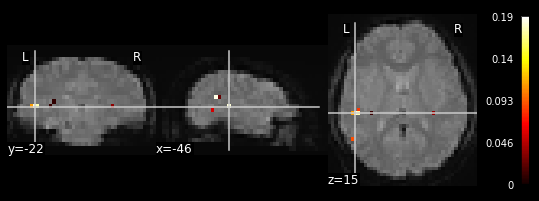

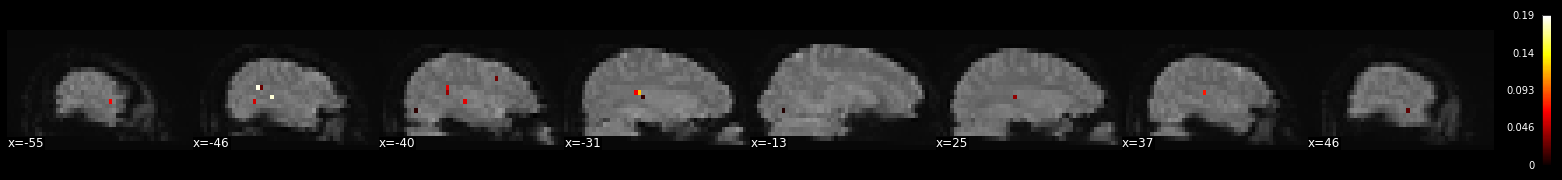

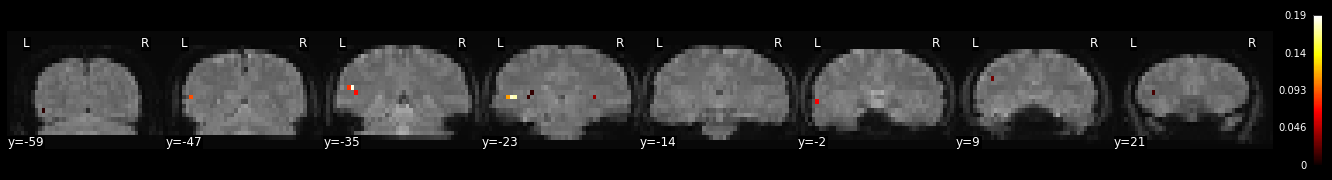

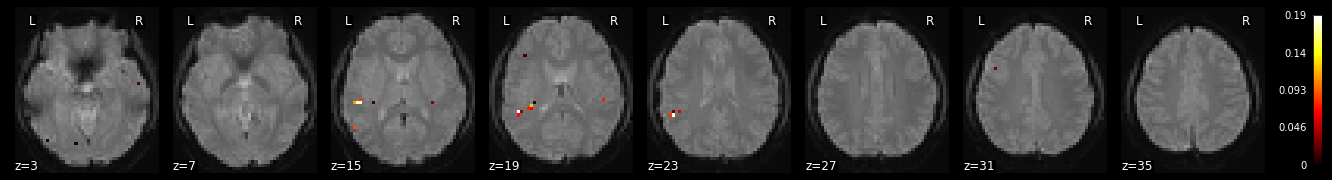

In [102]:
from nilearn.plotting import plot_stat_map,plot_glass_brain
plot_stat_map(score_map_img,bg_img=fmri_mean)
plt.show()
plot_stat_map(score_map_img,bg_img=fmri_mean,cut_coords=8,display_mode='x')
plt.show()
plot_stat_map(score_map_img,bg_img=fmri_mean,cut_coords=8,display_mode='y')
plt.show()
plot_stat_map(score_map_img,bg_img=fmri_mean,cut_coords=8,display_mode='z')
plt.show()